In [1]:
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt

test = pd.read_csv("data/activity_test_blanked.csv", header=None)
test.columns = ["uniprot_id", "mol_id", "activity"]
test["mol_id"] = test["mol_id"].str.strip()

train = pd.read_csv("data/activity_train.csv", header=None)
train.columns = ["uniprot_id", "mol_id", "activity"]
train["mol_id"] = train["mol_id"].str.strip()


with open("data/mol_bits.pkl", "rb") as f:
    data = pickle.load(f)


# Extracting unique features for sparse matrix dims
all_feats = set()
for feats_set in data.values():
    all_feats.update(feats_set)

n_feats = max(all_feats) + 1  # 0-based indexing

# Creating sparse matrix mol feats
rows, cols = [], []
for i, (uniprot_id, feats_set) in enumerate(data.items()):
    rows.extend([i] * len(feats_set))
    cols.extend(feats_set)

mol_ids = list(data.keys())

mol_feats = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(len(data), n_feats))

mol_feats = mol_feats.T  # Transposing to have features as rows

In [2]:
Full_table = train.pivot(
    index="uniprot_id", columns="mol_id", values="activity"
).fillna(0)

## Latent Factors
- Transform Prots x Molecules matrix into a product of 2 matrices
$$ R = Q \times P^T $$
- SVD ------> $R = U \sum V^T$
    - $P = U$ 
    - $Q = \sum \times V^T$

In [3]:
# Full table into csr matrix
Full_table

mol_id,CHEMBL10,CHEMBL1000,CHEMBL100003,CHEMBL100004,CHEMBL100045,CHEMBL100052,CHEMBL10007,CHEMBL100071,CHEMBL10009,CHEMBL100104,...,CHEMBL99939,CHEMBL99967,CHEMBL9997,CHEMBL99979,CHEMBL9998,CHEMBL99982,CHEMBL99983,CHEMBL99987,CHEMBL9999,CHEMBL99994
uniprot_id,,,,,,,,,,,,,,,,,,,,,
O14842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O95665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UBY5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9UKP6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9Y5N1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## SVD on full_table

U, S, V = svd(Full_table, full_matrices=False)


def get_factors(U, S, Vt, k=10):
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    P = U_k.copy()
    Q = (S_k @ Vt_k).T
    return P, Q


def masked_MSE(R, R_hat):
    mask = (R > 0) * 1
    return np.sum((mask * (R - R_hat)) ** 2) / np.sum(mask)


P, Q = get_factors(U, S, V, k=128)

In [5]:
np.argwhere(Full_table.values > 0)

array([[    0,  8644],
       [    0,  8646],
       [    0,  8647],
       ...,
       [  143, 69686],
       [  143, 69736],
       [  143, 69776]])

In [6]:
Full_table.values[0, 8646]

6.0

In [7]:
P[0] @ Q[8646]

6.0

K=2 MSE=0.644430749246905
K=3 MSE=0.5994418049680578
K=4 MSE=0.557052587648399
K=5 MSE=0.5224802723462036
K=6 MSE=0.4926186285940211
K=7 MSE=0.462431953947692
K=8 MSE=0.43589664340254036
K=9 MSE=0.41495505829863594
K=10 MSE=0.39393775903898187
K=11 MSE=0.37637546195208665
K=12 MSE=0.36168928651229754
K=13 MSE=0.34763202674473936
K=14 MSE=0.33373114869681125
K=15 MSE=0.3199565473656912
K=16 MSE=0.3085047966399771
K=17 MSE=0.29358904849858636
K=18 MSE=0.2830821511909918
K=19 MSE=0.27360340324821153
K=20 MSE=0.2629920922313565
K=21 MSE=0.2528768606504734
K=22 MSE=0.24623843517802335
K=23 MSE=0.23661509320796206
K=24 MSE=0.22781271897934247
K=25 MSE=0.218780970536657
K=26 MSE=0.20985543475232943
K=27 MSE=0.20156226764013305
K=28 MSE=0.19458668505719295
K=29 MSE=0.18827560724473483


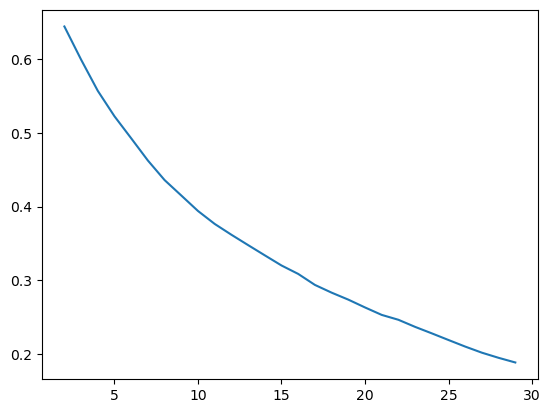

In [10]:
# calc error
# the use of mask is to quantify errors only on non zero ratings

R = P @ Q.T

mses = []
for k in range(2, 30):
    P, Q = get_factors(U, S, V, k=k)
    R_hat = P @ Q.T
    mse = masked_MSE(R, R_hat)
    mses.append(mse)
    print(f"K={k} MSE={mse}")

plt.plot(range(2, 30), mses)

### Regularized Stochastic Gradient Descent

We can have better results with SGD if we penalize the size of the factors in the P and Q matrices

$$ \min_{P,Q} \sum(r_{ui} - q_i.p^T_u) ^2 + \lambda\left[ \sum_u||p_u|| + \sum_i||q_i|| \right]$$

As such the partial derivatives change 

$$ \nabla Q_{ik} = \sum\left(-2(r_{ui} - q_i.p^T_u)p_{uk} + 2\lambda_q q_{ik} \right) $$

$$ \nabla P_{uk} = \sum\left(-2(r_{ui} - q_i.p^T_u)q_{ik} + 2\lambda_p p_{uk} \right) $$

But with this the update procedure is exactly the same as above, so we just need to update our `run_epoch` function with 2 new parameters for the regularization constants to apply
## SGD


In [6]:
k = 10

P, Q = get_factors(U, S, V, k=k)
# performing GD